# Overview

This notebook describes the different stages to build up different machine learning models trained over the dataset called **ISOT** by using  both **Word2Vec** and **Glove** tokenisation, for the automatic fake news detection

List of Machine Learning algorithms included 
- SVM
- Random Forest
- XgBoost
- KNN
- Naive Bayes
- Logistic Regression



## 1. Loading Python libraries

In [1]:
import numpy as np
import pandas as pd
import warnings
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import json
import tldextract   # Accurately separates a URL's subdomain, domain, and public suffix
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import re
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import nltk 
import spacy
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from wordcloud import WordCloud, ImageColorGenerator,STOPWORDS
import gensim
from gensim.parsing.preprocessing import STOPWORDS as gensim_stopwords
import copy
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords,wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer,LancasterStemmer
from sklearn.metrics import f1_score
from pprint import pprint
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', 1000)

[nltk_data] Downloading package stopwords to
[nltk_data]     /gpfs/home/psc21zcu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /gpfs/home/psc21zcu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /gpfs/home/psc21zcu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /gpfs/home/psc21zcu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Loading the ISOT Full Dataset  -- After combined fake and real news  in the previous notebook   "ISOT_ML_Classifiers_TfiDF_Tokenisation"

In [2]:
isot_full_df = pd.read_csv("Updated//ISOT_Combined_FullData.csv")

#### Dropping the columns 'title' , 'text' and 'date'

In [3]:
isot_full_df = isot_full_df.drop(columns = ['title','text', 'subject','date','title_length','body_length','date'])

In [4]:
isot_full_df=isot_full_df.reset_index(drop=True)

#### Preprocess the fulltext column using the built in cleaner option in gensim library

In [ ]:
# Clean data using the built in cleaner in gensim
isot_full_df['cleantext'] = isot_full_df['fulltext'].apply(lambda x: gensim.utils.simple_preprocess(x)

***

## 2. Model Training and Evaluation

### Splitting dataset into train and test

In [7]:
X=isot_full_df['cleantext']
y=isot_full_df['class']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=0)

####  User defined helper functions to find out the accuracy score metrics and creation of model comparison table


- The function named **metrics** is using to calculate the score of the different metrics such as Accuracy, Precision, Recall, F1Score and ROC AUC score for the given classifier with test data


- The function named **model_comparison_table** is using to create dataframe to list down all the classifiers with the metrics scores for the comparison purpose

In [9]:
import timeit
from timeit import default_timer as timer
from datetime import timedelta
 


def metrics(X_test,y_test,clf):
    predictions=clf.predict(X_test)
    #predictions=(clf.predict_proba(X_test)[:,1] >= 0.3).astype(bool)
    print("confusion_matrix :")
    print(confusion_matrix(y_test,predictions))
    print("Accuracy Score :")
    print(accuracy_score(y_test, predictions))
    print("Classification Report :")
    print(classification_report(y_test, predictions))
    print("F1 score :")
    print(f1_score(y_test, predictions))
    print("ROC AUC Score")
    y_pred_proba = clf.predict_proba(X_test)
    print(roc_auc_score(y_test, y_pred_proba[:,1]) )
    print("------------------------------")

    
def model_comparison_table(X_test,y_test,classifier_list):
    dict_clf={}
    for clf_name,clf in classifier_list:
        predictions=clf.predict(X_test)
        y_pred_proba = clf.predict_proba(X_test)
        accuracy=accuracy_score(y_test, predictions)
        precision=precision_score(y_test,predictions,average='macro').round(2)
        recall=recall_score(y_test,predictions)
        f1score=f1_score(y_test,predictions).round(2)
        ROC_AUC=roc_auc_score(y_test, y_pred_proba[:,1])
        dict_clf[clf_name]=[accuracy,precision,recall,f1score,ROC_AUC]
    df_models_scores = pd.DataFrame(dict_clf, index=['Accuracy', 'Precision', 'Recall', 'F1 Score','roc_auc_score'])
    return df_models_scores

#### User defined helper functions to create the confusion matrix and normalised confusion matrix 

The below scripts is using to create the confusion matrix and normalised confusion matrix based on the predictions and actual truth lables

In [10]:
# Helper function to plot confusion matrix and normalised confusion matrix plot
def confusn_mtrx_plot(cm,path):
    from sklearn.metrics import confusion_matrix
    # Y_pred_evc = evc_mdl.predict(test_X)
    #cm = confusion_matrix(ytrue, y_pred)

    fig = plt.figure(figsize=(6, 5), dpi=60)
    ax = plt.subplot()
    sns.set(font_scale=1.4) # Adjust to fit
    sns.heatmap(cm, annot=True, ax=ax, cmap="GnBu", fmt="g");  
    #sns.heatmap(cm/np.sum(cm), annot=True, ax=ax[1], cmap="GnBu", fmt="g");  

    # Labels, title and ticks
    label_font = {'size':'18'}  # Adjust to fit
    ax.set_xlabel('Predicted', fontdict=label_font);
    ax.set_ylabel('Actuals', fontdict=label_font);

    title_font = {'size':'20'}  # Adjust to fit
    ax.set_title('Confusion Matrix', fontdict=title_font);

    ax.tick_params(axis='both', which='major', labelsize=15)  # Adjust to fit
    ax.xaxis.set_ticklabels(['Real', 'Fake']);
    ax.yaxis.set_ticklabels(['Real', 'Fake']);
    #fig.show()
    fig.savefig(path)
    
def norm_confusn_mtrx_plot(cm,path):
    fig = plt.figure(figsize=(6, 5), dpi=60)
    ax = plt.subplot()
    sns.set(font_scale=1.4) # Adjust to fit
    sns.heatmap(cm/np.sum(cm), annot=True, ax=ax, cmap="GnBu",fmt='.2%');  

    # Labels, title and ticks
    label_font = {'size':'18'}  # Adjust to fit
    ax.set_xlabel('Predicted', fontdict=label_font);
    ax.set_ylabel('Actuals', fontdict=label_font);

    title_font = {'size':'18'}  # Adjust to fit
    ax.set_title('Normalised Confusion Matrix', fontdict=title_font);

    ax.tick_params(axis='both', which='major', labelsize=15)  # Adjust to fit
    ax.xaxis.set_ticklabels(['Real', 'Fake']);
    ax.yaxis.set_ticklabels(['Real', 'Fake']);
    fig.savefig(path)

### Feature Extractions using pretrained word2vec model

#### Load Gensim Downloader library

In [11]:
import gensim.downloader

##### Download the  pretrained model

In [13]:
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

#### After downloading it, you can load it as follows by specified the downloaded path

In [14]:
path_to_model = 'Embeddings//GoogleNews-vectors-negative300.bin'

In [15]:
from gensim.models.keyedvectors import KeyedVectors
%time w2v_model = KeyedVectors.load_word2vec_format(path_to_model, binary=True)
print('done loading Word2Vec')

CPU times: user 18.4 s, sys: 1.54 s, total: 20 s
Wall time: 20 s
done loading Word2Vec


#### Then inspect the model by getting the list of index of key values from the pretrained model

In [16]:
#Inspect the model
word2vec_vocab = list(w2v_model.index_to_key)

In [17]:
word2vec_vocab_lower = [item.lower() for item in word2vec_vocab]

#### User defined Function to create a feature vector by averaging all embeddings for the given sentence using the below user defined function

In [18]:
def embedding_feats(list_of_lists):
    DIMENSION = 300
    zero_vector = np.zeros(DIMENSION)
    feats = []
    for tokens in list_of_lists:
        feat_for_this =  np.zeros(DIMENSION)
        count_for_this = 0 + 1e-5 # to avoid divide-by-zero 
        for token in tokens:
            if token in w2v_model:
                feat_for_this += w2v_model[token]
                count_for_this +=1
        if(count_for_this!=0):
            feats.append(feat_for_this/count_for_this) 
        else:
            feats.append(zero_vector)
    return feats



30616


#### Then fit the training data and transform both training and test data

In [19]:
train_vectors = embedding_feats(X_train)
test_vectors = embedding_feats(X_test)
print(len(test_vectors))


7654


***
## Model Training 

### RandomForest

**Initialise the  model and  fit using train data and save it to a path**

In [24]:
rf = RandomForestClassifier(random_state=0)
rf_clf = rf.fit(train_vectors, y_train.values.ravel())

In [25]:
import pickle
# save the model to disk
filename = 'outputs//isot_ml_word2vec//isot_ml_RF_word2vec.sav'
pickle.dump(rf_clf, open(filename, 'wb'))
print('RandomForest - Completed')

RandomForest - Completed


**Load the saved model and predict using test data and measure the accuracy metrics**

In [26]:
#Loading the model
filename = 'outputs//isot_ml_word2vec//isot_ml_RF_word2vec.sav'

rf_clf_tuned = pickle.load(open(filename, 'rb'))
# result = rf_model_loaded.score(X_test_tfidf, y_test)
# print(result)


pred = rf_clf_tuned.predict(test_vectors)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))


Accuracy score : 0.9332375228638621
Confusion matrix : 
 [[3995  169]
 [ 342 3148]]
Classification Report
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      4164
           1       0.95      0.90      0.92      3490

    accuracy                           0.93      7654
   macro avg       0.94      0.93      0.93      7654
weighted avg       0.93      0.93      0.93      7654

Precision : 0.9490503466988243
Recall : 0.9020057306590258
F1 Score : 0.9249302188923167


**Save the classification report to csv**

In [27]:
report=classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//isot_ml_word2vec//model_ISOT_RF_WORD2VEC_clasifctnrpt.csv")
df.head()

,precision,recall,f1-score,support
0,0.921144,0.959414,0.939889,4164.000000
1,0.949050,0.902006,0.924930,3490.000000
accuracy,0.933238,0.933238,0.933238,0.933238
macro avg,0.935097,0.930710,0.932410,7654.000000
weighted avg,0.933868,0.933238,0.933068,7654.000000


**Plot confusion matrix using the user defined functions as mentioned above earlier**

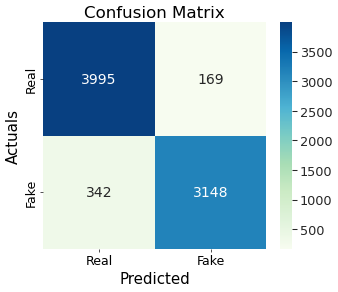

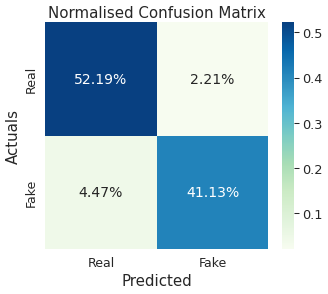

In [28]:
cm=confusion_matrix(y_test, pred)
path1="outputs//isot_ml_word2vec//isot_ml_RF_w2v_cmtrx.png"
path2="outputs//isot_ml_word2vec//isot_ml_RF_w2v_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

### Support Vector Machine

**Initialise the  model and  fit using train data and save it to a path**

In [32]:
svm_clf=SVC(random_state=0,probability=True)

In [33]:
svm_clf.fit(train_vectors,y_train)

# save the model to disk
filename = 'outputs//isot_ml_word2vec//isot_ml_SVM_word2vec.sav'
pickle.dump(svm_clf, open(filename, 'wb'))
print('SVM - Completed')

SVM - Completed


**Load the saved model and predict using test data and measure the accuracy metrics**

In [34]:
#Loading the model
filename = 'outputs//isot_ml_word2vec//isot_ml_SVM_word2vec.sav'

svm_clf_tuned = pickle.load(open(filename, 'rb'))
# result = rf_model_loaded.score(X_test_tfidf, y_test)
# print(result)


pred = svm_clf_tuned.predict(test_vectors)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))


Accuracy score : 0.9702116540371047
Confusion matrix : 
 [[4069   95]
 [ 133 3357]]
Classification Report
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      4164
           1       0.97      0.96      0.97      3490

    accuracy                           0.97      7654
   macro avg       0.97      0.97      0.97      7654
weighted avg       0.97      0.97      0.97      7654

Precision : 0.9724797219003476
Recall : 0.9618911174785101
F1 Score : 0.9671564390665515


**Save the classification report to csv**

In [35]:
report=classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//isot_ml_word2vec//model_ISOT_SVM_WORD2VEC_clasifctnrpt.csv")
df.head()

,precision,recall,f1-score,support
0,0.968348,0.977185,0.972747,4164.000000
1,0.972480,0.961891,0.967156,3490.000000
accuracy,0.970212,0.970212,0.970212,0.970212
macro avg,0.970414,0.969538,0.969952,7654.000000
weighted avg,0.970232,0.970212,0.970198,7654.000000


**Plot confusion matrix using the user defined functions as mentioned above earlier**

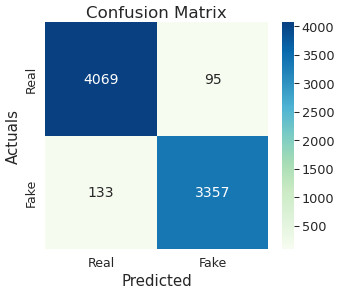

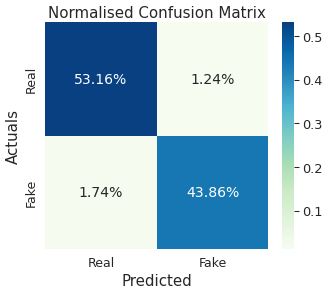

In [37]:
cm=confusion_matrix(y_test, pred)
path1="outputs//isot_ml_word2vec//isot_ml_SVM_w2v_cmtrx.png"
path2="outputs//isot_ml_word2vec//isot_ml_SVM_w2v_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

## KNN

**Initialise the  model and  fit using train data and save it to a path**

In [38]:
#Create KNN Object.
knn_clf = KNeighborsClassifier()

In [39]:
knn_clf.fit(train_vectors,y_train)

# save the model to disk
filename = 'outputs//isot_ml_word2vec//isot_ml_KNN_word2vec.sav'
pickle.dump(knn_clf, open(filename, 'wb'))
print('KNN - Completed')

KNN - Completed


**Load the saved model and predict using test data and measure the accuracy metrics**

In [40]:
#Loading the model
filename = 'outputs//isot_ml_word2vec//isot_ml_KNN_word2vec.sav'

knn_clf_tuned = pickle.load(open(filename, 'rb'))
# result = rf_model_loaded.score(X_test_tfidf, y_test)
# print(result)


pred = knn_clf_tuned.predict(test_vectors)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))


Accuracy score : 0.9376796446302587
Confusion matrix : 
 [[4041  123]
 [ 354 3136]]
Classification Report
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      4164
           1       0.96      0.90      0.93      3490

    accuracy                           0.94      7654
   macro avg       0.94      0.93      0.94      7654
weighted avg       0.94      0.94      0.94      7654

Precision : 0.9622583614605708
Recall : 0.898567335243553
F1 Score : 0.9293228626463179


**Save the classification report to csv**

In [41]:
report=classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//isot_ml_word2vec//model_ISOT_KNN_WORD2VEC_clasifctnrpt.csv")
df.head()

,precision,recall,f1-score,support
0,0.919454,0.970461,0.944269,4164.00000
1,0.962258,0.898567,0.929323,3490.00000
accuracy,0.937680,0.937680,0.937680,0.93768
macro avg,0.940856,0.934514,0.936796,7654.00000
weighted avg,0.938971,0.937680,0.937454,7654.00000


**Plot confusion matrix using the user defined functions as mentioned above earlier**

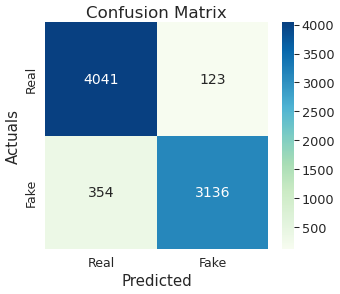

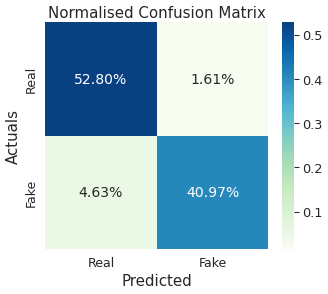

In [43]:
cm=confusion_matrix(y_test, pred)
path1="outputs//isot_ml_word2vec//isot_ml_KNN_w2v_cmtrx.png"
path2="outputs//isot_ml_word2vec//isot_ml_KNN_w2v_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

### Xgboost

**Initialise the  model and  fit using train data and save it to a path**

In [44]:
#Create KNN Object.
xg_clf=XGBClassifier(random_state=0)

xg_clf.fit(train_vectors,y_train)

# save the model to disk
filename = 'outputs//isot_ml_word2vec//isot_ml_XG_word2vec.sav'
pickle.dump(xg_clf, open(filename, 'wb'))
print('XgBoost - Completed')


XgBoost - Completed


**Load the saved model and predict using test data and measure the accuracy metrics**

In [45]:
#Loading the model
filename = 'outputs//isot_ml_word2vec//isot_ml_XG_word2vec.sav'

xg_clf_tuned = pickle.load(open(filename, 'rb'))
# result = rf_model_loaded.score(X_test_tfidf, y_test)
# print(result)


pred = xg_clf_tuned.predict(test_vectors)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))


Accuracy score : 0.9608048079435589
Confusion matrix : 
 [[4041  123]
 [ 177 3313]]
Classification Report
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      4164
           1       0.96      0.95      0.96      3490

    accuracy                           0.96      7654
   macro avg       0.96      0.96      0.96      7654
weighted avg       0.96      0.96      0.96      7654

Precision : 0.9642025611175786
Recall : 0.9492836676217765
F1 Score : 0.9566849552411204


**Save the classification report to csv**

In [46]:
report=classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//isot_ml_word2vec//model_ISOT_XG_WORD2VEC_clasifctnrpt.csv")
df.head()

,precision,recall,f1-score,support
0,0.958037,0.970461,0.964209,4164.000000
1,0.964203,0.949284,0.956685,3490.000000
accuracy,0.960805,0.960805,0.960805,0.960805
macro avg,0.961120,0.959872,0.960447,7654.000000
weighted avg,0.960848,0.960805,0.960778,7654.000000


**Plot confusion matrix using the user defined functions as mentioned above earlier**

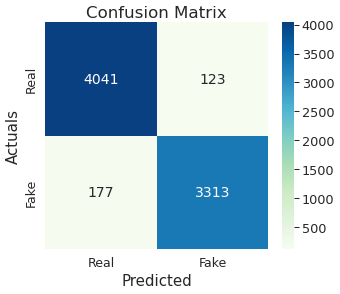

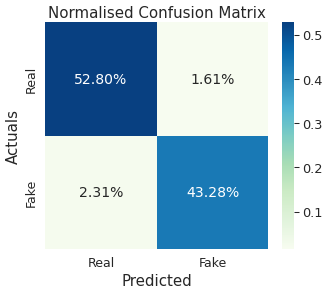

In [48]:
cm=confusion_matrix(y_test, pred)
path1="outputs//isot_ml_word2vec//isot_ml_XG_w2v_cmtrx.png"
path2="outputs//isot_ml_word2vec//isot_ml_XG_w2v_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

### Naiva Bayes

**Initialise the  model and  fit using train data and save it to a path**

In [49]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
nb_clf=GaussianNB()
#p = Pipeline([('Normalizing',MinMaxScaler()),('MultinomialNB',MultinomialNB())])
nb_clf.fit(train_vectors,y_train) 

# save the model to disk
filename = 'outputs//isot_ml_word2vec//isot_ml_NB_word2vec.sav'
pickle.dump(nb_clf, open(filename, 'wb'))
print('Naive Bayes - Completed')

Naive Bayes - Completed


**Load the saved model and predict using test data and measure the accuracy metrics**

In [50]:
#Loading the model
filename = 'outputs//isot_ml_word2vec//isot_ml_NB_word2vec.sav'

nb_clf_tuned = pickle.load(open(filename, 'rb'))
# result = rf_model_loaded.score(X_test_tfidf, y_test)
# print(result)


pred = nb_clf_tuned.predict(test_vectors)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))


Accuracy score : 0.8881630519989548
Confusion matrix : 
 [[3752  412]
 [ 444 3046]]
Classification Report
              precision    recall  f1-score   support

           0       0.89      0.90      0.90      4164
           1       0.88      0.87      0.88      3490

    accuracy                           0.89      7654
   macro avg       0.89      0.89      0.89      7654
weighted avg       0.89      0.89      0.89      7654

Precision : 0.8808559861191441
Recall : 0.8727793696275071
F1 Score : 0.8767990788716177


**Save the classification report to csv**

In [51]:
report=classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//isot_ml_word2vec//model_ISOT_NB_WORD2VEC_clasifctnrpt.csv")
df.head()

,precision,recall,f1-score,support
0,0.894185,0.901057,0.897608,4164.000000
1,0.880856,0.872779,0.876799,3490.000000
accuracy,0.888163,0.888163,0.888163,0.888163
macro avg,0.887520,0.886918,0.887203,7654.000000
weighted avg,0.888107,0.888163,0.888120,7654.000000


**Plot confusion matrix using the user defined functions as mentioned above earlier**

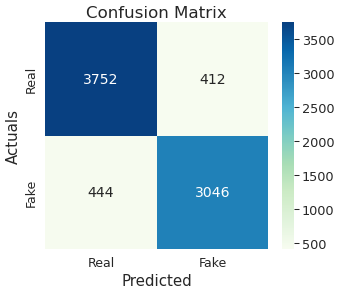

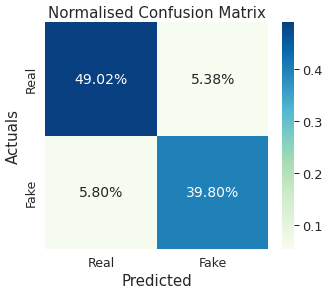

In [53]:
cm=confusion_matrix(y_test, pred)
path1="outputs//isot_ml_word2vec//isot_ml_NB_w2v_cmtrx.png"
path2="outputs//isot_ml_word2vec//isot_ml_NB_w2v_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

### Logistic Regression

**Initialise the  model and  fit using train data and save it to a path**

In [54]:
from sklearn.linear_model import LogisticRegression

In [55]:
logticreg_clf=LogisticRegression()

logticreg_clf.fit(train_vectors,y_train)

# save the model to disk
filename = 'outputs//isot_ml_word2vec//isot_ml_LR_word2vec.sav'
pickle.dump(nb_clf, open(filename, 'wb'))
print('Logistic - Completed')

Logistic - Completed


**Load the saved model and predict using test data and measure the accuracy metrics**

In [56]:
#Loading the model
filename = 'outputs//isot_ml_word2vec//isot_ml_LR_word2vec.sav'

lr_clf_tuned = pickle.load(open(filename, 'rb'))
# result = rf_model_loaded.score(X_test_tfidf, y_test)
# print(result)


pred = lr_clf_tuned.predict(test_vectors)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))


Accuracy score : 0.8881630519989548
Confusion matrix : 
 [[3752  412]
 [ 444 3046]]
Classification Report
              precision    recall  f1-score   support

           0       0.89      0.90      0.90      4164
           1       0.88      0.87      0.88      3490

    accuracy                           0.89      7654
   macro avg       0.89      0.89      0.89      7654
weighted avg       0.89      0.89      0.89      7654

Precision : 0.8808559861191441
Recall : 0.8727793696275071
F1 Score : 0.8767990788716177


**Save the classification report to csv**

In [57]:
report=classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//isot_ml_word2vec//model_ISOT_LR_WORD2VEC_clasifctnrpt.csv")
df.head()

,precision,recall,f1-score,support
0,0.894185,0.901057,0.897608,4164.000000
1,0.880856,0.872779,0.876799,3490.000000
accuracy,0.888163,0.888163,0.888163,0.888163
macro avg,0.887520,0.886918,0.887203,7654.000000
weighted avg,0.888107,0.888163,0.888120,7654.000000


**Plot confusion matrix using the user defined functions as mentioned above earlier**

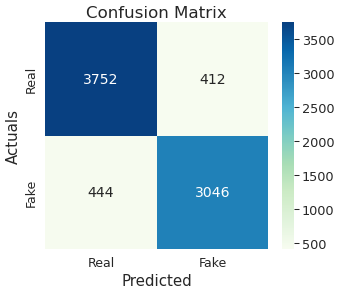

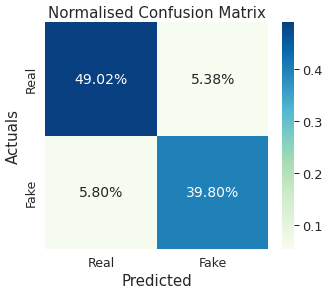

In [59]:
cm=confusion_matrix(y_test, pred)
path1="outputs//isot_ml_word2vec//isot_ml_LR_w2v_cmtrx.png"
path2="outputs//isot_ml_word2vec//isot_ml_LR_w2v_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

### ROC AUC Curve plot using all the algorithms

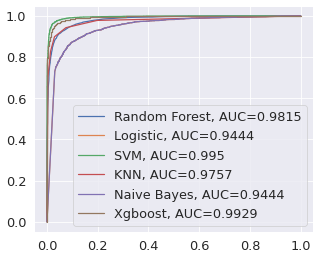

In [61]:
#set up plotting area
fig = plt.figure(figsize=(6, 5), dpi=60)
ax = plt.subplot()
#fit RF model and plot ROC curve

y_pred = rf_clf_tuned.predict_proba(test_vectors)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Random Forest, AUC="+str(auc))

#fit Logistic model and plot ROC curve

y_pred = lr_clf_tuned.predict_proba(test_vectors)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Logistic, AUC="+str(auc))


#fit SVM model and plot ROC curve

y_pred = svm_clf_tuned.predict_proba(test_vectors)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="SVM, AUC="+str(auc))


#fit KNN model and plot ROC curve


y_pred = knn_clf_tuned.predict_proba(test_vectors)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="KNN, AUC="+str(auc))

#fit Naive Bayes model and plot ROC curve

y_pred = nb_clf_tuned.predict_proba(test_vectors)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Naive Bayes, AUC="+str(auc))

#fit Xgboost model and plot ROC curve

y_pred = xg_clf_tuned.predict_proba(test_vectors)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Xgboost, AUC="+str(auc))

#add legend
plt.legend()
fig.savefig("outputs//isot_ml_word2vec//ROC_AUC.png")

### Consolidating all classifiers accuracy scores

In [62]:
classifiers = [('Logistic Regression',lr_clf_tuned),('Naive Bayes',nb_clf_tuned),('Xgboost',xg_clf_tuned),
              ('KNN',knn_clf_tuned),('Random Forest',rf_clf_tuned),("SVM",svm_clf_tuned)]

In [63]:
df_model_scores=model_comparison_table(test_vectors,y_test,classifiers)
df_model_scores.head(20).T.sort_values(by='Accuracy', ascending=False)
df_model_scores.to_csv("outputs//isot_ml_word2vec/comparison_scores.csv")

In [64]:
df_model_scores.head()

,Logistic Regression,Naive Bayes,Xgboost,KNN,Random Forest,SVM
Accuracy,0.888163,0.888163,0.960805,0.937680,0.933238,0.970212
Precision,0.890000,0.890000,0.960000,0.940000,0.940000,0.970000
Recall,0.872779,0.872779,0.949284,0.898567,0.902006,0.961891
F1 Score,0.880000,0.880000,0.960000,0.930000,0.920000,0.970000
roc_auc_score,0.944391,0.944391,0.992910,0.975750,0.981484,0.994976


## Feature Extraction using Pretrained Glove

##### Download the pretrained zip file

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

#### Load the downloaded the 300 dimension Glove pretrained model "glove.6B.300d.txt" in a path and convert to word2vec format",

In [11]:
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

In [12]:
path_to_model = '//gpfs//home//psc21zcu//FakeNews_Detection/Dissertation_Work//Embeddings//glove.6B.300d.txt'
output_file = '//gpfs//home//psc21zcu//FakeNews_Detection/Dissertation_Work//Embeddings///gensim_glove.6B.300d.txt'
glove2word2vec(path_to_model, output_file)

(400000, 300)

#### Then load the converted glove model 

In [14]:
%time glove_model = KeyedVectors.load_word2vec_format(output_file, binary=False)
print('done loading Glove Pretrained Embedding')

CPU times: user 41.8 s, sys: 547 ms, total: 42.3 s
Wall time: 42.5 s
done loading Glove Pretrained Embedding


### Function to create a feature vector by averaging all embeddings for the given sentence 

In [15]:
# Creating a feature vector by averaging all embeddings for all sentences
def glove_embedding_feats(list_of_lists):
    DIMENSION = 300
    zero_vector = np.zeros(DIMENSION)
    feats = []
    for tokens in list_of_lists:
        feat_for_this =  np.zeros(DIMENSION)
        count_for_this = 0 + 1e-5 # to avoid divide-by-zero 
        for token in tokens:
            if token in glove_model:
                feat_for_this += glove_model[token]
                count_for_this +=1
        if(count_for_this!=0):
            feats.append(feat_for_this/count_for_this) 
        else:
            feats.append(zero_vector)
    return feats



30616


#### Then fit the training data and transform both training and test data

In [16]:
glove_train_vectors = glove_embedding_feats(X_train)
glove_test_vectors = glove_embedding_feats(X_test)
print(len(glove_test_vectors))

7654


### RandomForest

**Initialise the  model and  fit using train data and save it to a path**

In [18]:
rf = RandomForestClassifier(random_state=0)
rf_clf_g = rf.fit(glove_train_vectors, y_train.values.ravel())
import pickle
# save the model to disk
filename = 'outputs//isot_ml_glove//isot_ml_RF_glove.sav'
pickle.dump(rf_clf_g, open(filename, 'wb'))
print('RandomForest - Completed')

RandomForest - Completed


**Load the saved model and predict using test data and measure the accuracy metrics**

In [19]:
#Loading the model
filename = 'outputs//isot_ml_glove//isot_ml_RF_glove.sav'

rf_clf_tuned_g = pickle.load(open(filename, 'rb'))
# result = rf_model_loaded.score(X_test_tfidf, y_test)
# print(result)


pred = rf_clf_tuned_g.predict(glove_test_vectors)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))


Accuracy score : 0.9355892343872485
Confusion matrix : 
 [[3998  166]
 [ 327 3163]]
Classification Report
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      4164
           1       0.95      0.91      0.93      3490

    accuracy                           0.94      7654
   macro avg       0.94      0.93      0.93      7654
weighted avg       0.94      0.94      0.94      7654

Precision : 0.950135175728447
Recall : 0.9063037249283667
F1 Score : 0.9277020090922422


**Save the classification report to csv**

In [20]:
report=classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//isot_ml_glove//model_ISOT_RF_GLOVE_clasifctnrpt.csv")
df.head()

,precision,recall,f1-score,support
0,0.924393,0.960134,0.941925,4164.000000
1,0.950135,0.906304,0.927702,3490.000000
accuracy,0.935589,0.935589,0.935589,0.935589
macro avg,0.937264,0.933219,0.934813,7654.000000
weighted avg,0.936131,0.935589,0.935440,7654.000000


**Plot confusion matrix using the user defined functions as mentioned above earlier**

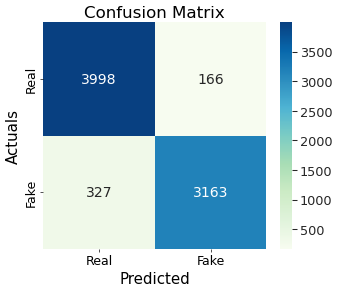

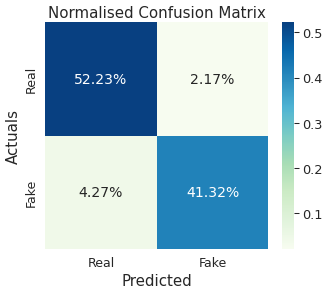

In [22]:
cm=confusion_matrix(y_test, pred)
path1="outputs//isot_ml_glove//isot_ml_RF_glove_cmtrx.png"
path2="outputs//isot_ml_glove//isot_ml_RF_glove_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

### Support Vector Machine

**Initialise the  model and  fit using train data and save it to a path**

In [23]:
svm_clf_g=SVC(random_state=0,probability=True)

In [24]:
svm_clf_g.fit(glove_train_vectors,y_train)

# save the model to disk
filename = 'outputs//isot_ml_glove//isot_ml_SVM_glove.sav'
pickle.dump(svm_clf_g, open(filename, 'wb'))
print('SVM - Completed')

SVM - Completed


**Load the saved model and predict using test data and measure the accuracy metrics**

In [25]:
#Loading the model
filename = 'outputs//isot_ml_glove//isot_ml_SVM_glove.sav'

svm_clf_tuned_g = pickle.load(open(filename, 'rb'))
# result = rf_model_loaded.score(X_test_tfidf, y_test)
# print(result)


pred = svm_clf_tuned_g.predict(glove_test_vectors)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))


Accuracy score : 0.9594983015416776
Confusion matrix : 
 [[4026  138]
 [ 172 3318]]
Classification Report
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      4164
           1       0.96      0.95      0.96      3490

    accuracy                           0.96      7654
   macro avg       0.96      0.96      0.96      7654
weighted avg       0.96      0.96      0.96      7654

Precision : 0.9600694444444444
Recall : 0.9507163323782235
F1 Score : 0.955369997120645


**Save the classification report to csv**

In [26]:
report=classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//isot_ml_glove//model_ISOT_SVM_GLOVE_clasifctnrpt.csv")
df.head()

,precision,recall,f1-score,support
0,0.959028,0.966859,0.962928,4164.000000
1,0.960069,0.950716,0.955370,3490.000000
accuracy,0.959498,0.959498,0.959498,0.959498
macro avg,0.959549,0.958788,0.959149,7654.000000
weighted avg,0.959503,0.959498,0.959482,7654.000000


**Plot confusion matrix using the user defined functions as mentioned above earlier**

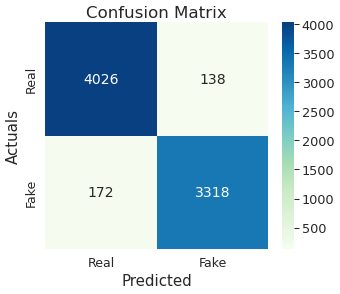

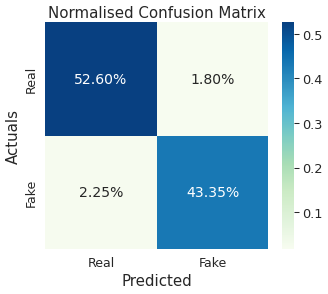

In [28]:
cm=confusion_matrix(y_test, pred)
path1="outputs//isot_ml_glove//isot_ml_SVM_glove_cmtrx.png"
path2="outputs//isot_ml_glove//isot_ml_SVM_glove_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

## KNN

**Initialise the  model and  fit using train data and save it to a path**

In [29]:
#Create KNN Object.
knn_clf_g = KNeighborsClassifier()

In [30]:
knn_clf_g.fit(glove_train_vectors,y_train)

# save the model to disk
filename = 'outputs//isot_ml_glove//isot_ml_KNN_glove.sav'
pickle.dump(knn_clf_g, open(filename, 'wb'))
print('KNN - Completed')

KNN - Completed


**Load the saved model and predict using test data and measure the accuracy metrics**

In [31]:
#Loading the model
filename = 'outputs//isot_ml_glove//isot_ml_KNN_glove.sav'

knn_clf_tuned_g = pickle.load(open(filename, 'rb'))
# result = rf_model_loaded.score(X_test_tfidf, y_test)
# print(result)


pred = knn_clf_tuned_g.predict(glove_test_vectors)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))


Accuracy score : 0.9385941991115756
Confusion matrix : 
 [[4030  134]
 [ 336 3154]]
Classification Report
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      4164
           1       0.96      0.90      0.93      3490

    accuracy                           0.94      7654
   macro avg       0.94      0.94      0.94      7654
weighted avg       0.94      0.94      0.94      7654

Precision : 0.9592457420924574
Recall : 0.9037249283667622
F1 Score : 0.9306580112127472


**Save the classification report to csv**

In [32]:
report=classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//isot_ml_glove//model_ISOT_KNN_GLOVE_clasifctnrpt.csv")
df.head()

,precision,recall,f1-score,support
0,0.923042,0.967819,0.944900,4164.000000
1,0.959246,0.903725,0.930658,3490.000000
accuracy,0.938594,0.938594,0.938594,0.938594
macro avg,0.941144,0.935772,0.937779,7654.000000
weighted avg,0.939550,0.938594,0.938406,7654.000000


**Plot confusion matrix using the user defined functions as mentioned above earlier**

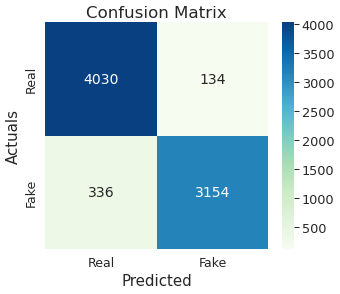

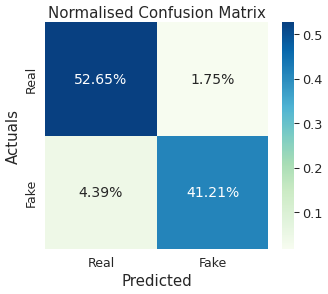

In [34]:
cm=confusion_matrix(y_test, pred)
path1="outputs//isot_ml_glove//isot_ml_KNN_glove_cmtrx.png"
path2="outputs//isot_ml_glove//isot_ml_KNN_glove_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

### Xgboost

**Initialise the  model and  fit using train data and save it to a path**

In [35]:
#Create KNN Object.
xg_clf_g=XGBClassifier(random_state=0)

xg_clf_g.fit(glove_train_vectors,y_train)

# save the model to disk
filename = 'outputs//isot_ml_glove//isot_ml_XG_glove.sav'
pickle.dump(xg_clf_g, open(filename, 'wb'))
print('XGBoost - Completed')


XGBoost - Completed


**Load the saved model and predict using test data and measure the accuracy metrics**

In [36]:
#Loading the model
filename = 'outputs//isot_ml_glove//isot_ml_XG_glove.sav'

xg_clf_tuned_g = pickle.load(open(filename, 'rb'))
# result = rf_model_loaded.score(X_test_tfidf, y_test)
# print(result)


pred = xg_clf_tuned_g.predict(glove_test_vectors)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))


Accuracy score : 0.9604128560229945
Confusion matrix : 
 [[4040  124]
 [ 179 3311]]
Classification Report
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      4164
           1       0.96      0.95      0.96      3490

    accuracy                           0.96      7654
   macro avg       0.96      0.96      0.96      7654
weighted avg       0.96      0.96      0.96      7654

Precision : 0.963901018922853
Recall : 0.9487106017191977
F1 Score : 0.956245487364621


**Save the classification report to csv**

In [37]:
report=classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//isot_ml_glove//model_ISOT_XG_GLOVE_clasifctnrpt.csv")
df.head()

,precision,recall,f1-score,support
0,0.957573,0.970221,0.963855,4164.000000
1,0.963901,0.948711,0.956245,3490.000000
accuracy,0.960413,0.960413,0.960413,0.960413
macro avg,0.960737,0.959466,0.960050,7654.000000
weighted avg,0.960458,0.960413,0.960386,7654.000000


**Plot confusion matrix using the user defined functions as mentioned above earlier**

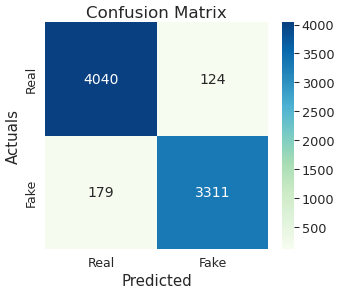

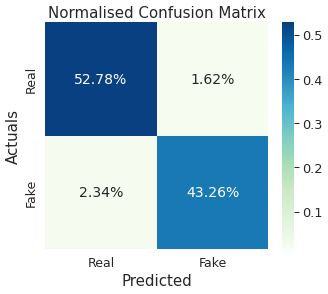

In [39]:
cm=confusion_matrix(y_test, pred)
path1="outputs//isot_ml_glove//isot_ml_XG_glove_cmtrx.png"
path2="outputs//isot_ml_glove//isot_ml_XG_glove_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

### Naiva Bayes

**Initialise the  model and  fit using train data and save it to a path**

In [42]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
nb_clf_g=GaussianNB()

nb_clf_g.fit(glove_train_vectors,y_train) 

# save the model to disk
filename = 'outputs//isot_ml_glove//isot_ml_NB_glove.sav'
pickle.dump(nb_clf_g, open(filename, 'wb'))
print('Naive Bayes - Completed')


Naive Bayes - Completed


**Load the saved model and predict using test data and measure the accuracy metrics**

In [43]:
#Loading the model
filename = 'outputs//isot_ml_glove//isot_ml_NB_glove.sav'

nb_clf_tuned_g = pickle.load(open(filename, 'rb'))
# result = rf_model_loaded.score(X_test_tfidf, y_test)
# print(result)


pred = nb_clf_tuned_g.predict(glove_test_vectors)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))


Accuracy score : 0.8800627123072903
Confusion matrix : 
 [[3656  508]
 [ 410 3080]]
Classification Report
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      4164
           1       0.86      0.88      0.87      3490

    accuracy                           0.88      7654
   macro avg       0.88      0.88      0.88      7654
weighted avg       0.88      0.88      0.88      7654

Precision : 0.8584169453734671
Recall : 0.8825214899713467
F1 Score : 0.8703023452952812


**Save the classification report to csv**

In [44]:
report=classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//isot_ml_glove//model_ISOT_NB_GLOVE_clasifctnrpt.csv")
df.head()

,precision,recall,f1-score,support
0,0.899164,0.878002,0.888457,4164.000000
1,0.858417,0.882521,0.870302,3490.000000
accuracy,0.880063,0.880063,0.880063,0.880063
macro avg,0.878790,0.880262,0.879380,7654.000000
weighted avg,0.880584,0.880063,0.880179,7654.000000


**Plot confusion matrix using the user defined functions as mentioned above earlier**

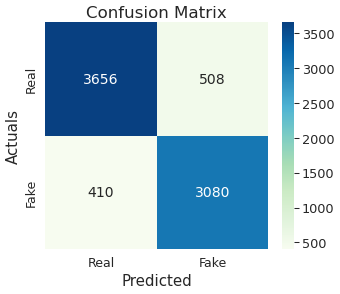

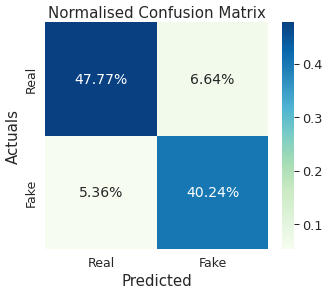

In [46]:
cm=confusion_matrix(y_test, pred)
path1="outputs//isot_ml_glove//isot_ml_NB_glove_cmtrx.png"
path2="outputs//isot_ml_glove//isot_ml_NB_glove_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

### Logistic Regression

**Initialise the  model and  fit using train data and save it to a path**

In [47]:
from sklearn.linear_model import LogisticRegression

In [48]:
logticreg_clf_g=LogisticRegression()

logticreg_clf_g.fit(glove_train_vectors,y_train)

# save the model to disk
filename = 'outputs//isot_ml_glove//isot_ml_LR_glove.sav'
pickle.dump(nb_clf_g, open(filename, 'wb'))
print('Logistic - Completed')


Logistic - Completed


**Load the saved model and predict using test data and measure the accuracy metrics**

In [49]:
#Loading the model
filename = 'outputs//isot_ml_glove//isot_ml_LR_glove.sav'

lr_clf_tuned_g = pickle.load(open(filename, 'rb'))
# result = rf_model_loaded.score(X_test_tfidf, y_test)
# print(result)


pred = lr_clf_tuned_g.predict(glove_test_vectors)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))


Accuracy score : 0.8800627123072903
Confusion matrix : 
 [[3656  508]
 [ 410 3080]]
Classification Report
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      4164
           1       0.86      0.88      0.87      3490

    accuracy                           0.88      7654
   macro avg       0.88      0.88      0.88      7654
weighted avg       0.88      0.88      0.88      7654

Precision : 0.8584169453734671
Recall : 0.8825214899713467
F1 Score : 0.8703023452952812


**Save the classification report to csv**

In [50]:
report=classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//isot_ml_glove//model_ISOT_LR_GLOVE_clasifctnrpt.csv")
df.head()

,precision,recall,f1-score,support
0,0.899164,0.878002,0.888457,4164.000000
1,0.858417,0.882521,0.870302,3490.000000
accuracy,0.880063,0.880063,0.880063,0.880063
macro avg,0.878790,0.880262,0.879380,7654.000000
weighted avg,0.880584,0.880063,0.880179,7654.000000


**Plot confusion matrix using the user defined functions as mentioned above earlier**

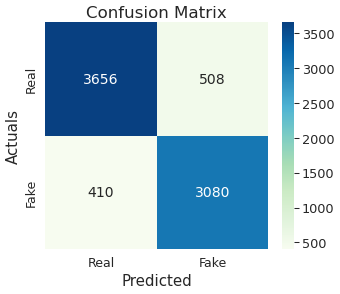

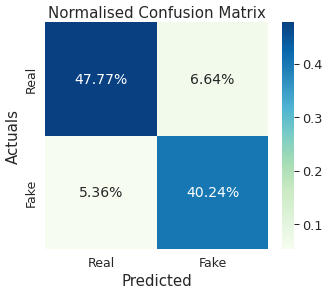

In [52]:
cm=confusion_matrix(y_test, pred)
path1="outputs//isot_ml_glove//isot_ml_LR_glove_cmtrx.png"
path2="outputs//isot_ml_glove//isot_ml_LR_glove_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

### ROC AUC Curve plot using all the algorithms

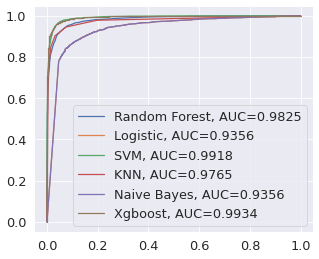

In [54]:
#set up plotting area
fig = plt.figure(figsize=(6, 5), dpi=60)
ax = plt.subplot()
#fit RF model and plot ROC curve

y_pred = rf_clf_tuned_g.predict_proba(glove_test_vectors)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Random Forest, AUC="+str(auc))

#fit Logistic model and plot ROC curve

y_pred = lr_clf_tuned_g.predict_proba(glove_test_vectors)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Logistic, AUC="+str(auc))


#fit SVM model and plot ROC curve

y_pred = svm_clf_tuned_g.predict_proba(glove_test_vectors)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="SVM, AUC="+str(auc))


#fit KNN model and plot ROC curve


y_pred = knn_clf_tuned_g.predict_proba(glove_test_vectors)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="KNN, AUC="+str(auc))

#fit Naive Bayes model and plot ROC curve

y_pred = nb_clf_tuned_g.predict_proba(glove_test_vectors)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Naive Bayes, AUC="+str(auc))

#fit Xgboost model and plot ROC curve

y_pred = xg_clf_tuned_g.predict_proba(glove_test_vectors)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Xgboost, AUC="+str(auc))

#add legend
plt.legend()
fig.savefig("outputs//isot_ml_glove//ROC_AUC.png")

### Consolidating all classifiers accuracy scores

In [55]:
classifiers = [('Logistic Regression',lr_clf_tuned_g),('Naive Bayes',nb_clf_tuned_g),('Xgboost',xg_clf_tuned_g),
              ('KNN',knn_clf_tuned_g),('Random Forest',rf_clf_tuned_g),("SVM",svm_clf_tuned_g)]

In [56]:
df_model_scores=model_comparison_table(glove_test_vectors,y_test,classifiers)
df_model_scores.head(20).T.sort_values(by='Accuracy', ascending=False)

,Accuracy,Precision,Recall,F1 Score,roc_auc_score
Xgboost,0.960413,0.96,0.948711,0.96,0.993443
SVM,0.959498,0.96,0.950716,0.96,0.991805
KNN,0.938594,0.94,0.903725,0.93,0.976491
Random Forest,0.935589,0.94,0.906304,0.93,0.982540
Logistic Regression,0.880063,0.88,0.882521,0.87,0.935605
Naive Bayes,0.880063,0.88,0.882521,0.87,0.935605


In [57]:
df_model_scores.to_csv("outputs//isot_ml_glove/comparison_scores.csv")